# MCP-HaloTag testing

## Data import

In [5]:
from transcription_pipeline import preprocessing_pipeline
RBSPWM_dataset1 = "test_data/2024-02-26/Halo-RBSPWM_embryo01"
RBSPWM_dataset2 = "test_data/2024-02-26/Halo-RBSPWM_embryo02"

RBSPWM_dataset3 = "test_data/2024-05-07/Halo552-RBSPWM_embryo01" # 1024x256, time res 4.2 seconds
RBSPWM_dataset4 = "test_data/2024-05-07/Halo552-RBSPWM_embryo02" # 800x300 

RBSPWM_dataset5 = "test_data/2024-05-09/Halo552-RBSPWM_embryo01" # 40x magnification

RBSPWM_dataset5_Josh = "../../Josh/transcription_pipeline-main/test_data/2024-05-09/Halo552-RBSPWM_embryo01/"

RBSVar2_dataset1 = "test_data/2024-07-23/Halo673_RBSVar2_embryo01"
RBSVar2_dataset2 = "test_data/2024-07-25/Halo673_RBSVar2_embryo01"

InputOutput_embryo1 = "test_data/InputOutput_MCPHaloTag/2024-03-07/embryo1"
InputOutput_embryo2 = "test_data/InputOutput_MCPHaloTag/2024-03-07/embryo2"

Bicistronic_embryo1 = "test_data/2024-09-03/Halo673_r1close_embryo01"
Bicistronic_embryo2 = "test_data/2024-03-07/Halo673_RBSVar2_embryo02"

RBSVar2_datasets = [
    "test_data/2024-07-23/Halo673_RBSVar2_embryo01",
    "test_data/2024-07-25/Halo673_RBSVar2_embryo01",# Imaged with yw; His2Av-mRFP; MCP-HaloTag
    "test_data/2024-09-03/Halo673_RBSVar2_embryo02",# Imaged with yw; +; MCP-HaloTag, His2Av-mRFP
]

MCP_mSG_datasets = [
    "test_data/2024-08-13/MCP-mSG,ParB-mScar_normWindow",
    "test_data/2024-10-31/MCP-mSG_ParB-mScar_RBSPWM_embryo01",
    "test_data/2024-10-31/MCP-mSG_ParB-mScar_RBSPWM_embryo02",
    "test_data/2024-11-05/MCP-mSG_ParB-mScar_RBSPWM_embryo01",
    ]

test_dataset_name = MCP_mSG_datasets[3]

`JAVA_HOME` environment variable set to /mnt/Data1/Nick/miniforge3/envs/transcription_pipeline


In [6]:
## Import from scratch
dataset = preprocessing_pipeline.DataImport(
    name_folder=test_dataset_name,
    trim_series=True,
    working_storage_mode='zarr',
    # import_previous=True, 
);
dataset.save();

/mnt/Data1/Nick/transcription_pipeline/transcription_pipeline/preprocessing/import_data.py:863: UserWarning: Could not align z-stack after series 0.
  warnings.warn(
/mnt/Data1/Nick/transcription_pipeline/transcription_pipeline/preprocessing/import_data.py:863: UserWarning: Could not align z-stack after series 1.
  warnings.warn(
/mnt/Data1/Nick/transcription_pipeline/transcription_pipeline/preprocessing/import_data.py:863: UserWarning: Could not align z-stack after series 2.
  warnings.warn(
/mnt/Data1/Nick/transcription_pipeline/transcription_pipeline/preprocessing/import_data.py:863: UserWarning: Could not align z-stack after series 3.
  warnings.warn(
/mnt/Data1/Nick/transcription_pipeline/transcription_pipeline/preprocessing/import_data.py:863: UserWarning: Could not align z-stack after series 4.
  warnings.warn(
/mnt/Data1/Nick/transcription_pipeline/transcription_pipeline/preprocessing/import_data.py:863: UserWarning: Could not align z-stack after series 5.
  warnings.warn(
/mnt

In [2]:
## Load from zarr
dataset = preprocessing_pipeline.DataImport(
    name_folder=test_dataset_name,
    trim_series=True,
    # working_storage_mode='zarr',
    import_previous=True, 
)

## Starting a Dask Client for parallelization

In [3]:
from dask.distributed import LocalCluster, Client

try:
    cluster = LocalCluster(
        host="localhost",
        scheduler_port=37763,
        threads_per_worker=1,
        n_workers=14,
        memory_limit="6GB",
    )
    
    client = Client(cluster)
except:
    cluster = LocalCluster(
        host="localhost",
        # scheduler_port=37763,
        threads_per_worker=1,
        n_workers=14,
        memory_limit="6GB",
    )
    
    client = Client(cluster)

print(client)

<Client: 'tcp://127.0.0.1:37763' processes=14 threads=14, memory=78.23 GiB>


In [ ]:
client.restart()

In [4]:
print(client.dashboard_link)

http://127.0.0.1:8787/status


## Nuclear Tracking

In [ ]:
# Run nuclear segmentation and tracking
from transcription_pipeline import nuclear_pipeline

In [ ]:
nuclear_tracking = nuclear_pipeline.Nuclear(
    data=dataset.channels_full_dataset[0],
    global_metadata=dataset.export_global_metadata[0],
    frame_metadata=dataset.export_frame_metadata[0],
    series_splits=dataset.series_splits,
    series_shifts=dataset.series_shifts,
    search_range_um=1.5,
    stitch=False,
    stitch_max_distance=4,
    stitch_max_frame_distance=2,
    client=client,
    keep_futures=False,
)

nuclear_tracking.track_nuclei(
        working_memory_mode="zarr",
        working_memory_folder=test_dataset_name,
        trackpy_log_path="".join([test_dataset_name, "trackpy_log"]),
    )
    # Saves tracked nuclear mask as a zarr, and pickles dataframes with segmentation and
    # tracking information.
nuclear_tracking.save_results(
        name_folder=test_dataset_name, save_array_as=None
    )

In [ ]:
nuclear_tracking = nuclear_pipeline.Nuclear()

nuclear_tracking.read_results(name_folder=test_dataset_name)

## Spot analysis

In [5]:
from transcription_pipeline import spot_pipeline

In [ ]:
# dataset.original_global_metadata

In [6]:
%%time

spot_tracking = spot_pipeline.Spot(
    data=dataset.channels_full_dataset[1],
    global_metadata=dataset.export_global_metadata[1],
    frame_metadata=dataset.export_frame_metadata[1],
    labels=None,#nuclear_tracking.reordered_labels,
    expand_distance=3,
    search_range_um=4.2,
    retrack_search_range_um=4.5,
    threshold_factor=1.3,
    memory=3,
    retrack_after_filter=False,
    stitch=True,
    min_track_length=0,
    series_splits=dataset.series_splits,
    series_shifts=dataset.series_shifts,
    keep_bandpass=False,
    keep_futures=False,
    keep_spot_labels=False,
    evaluate=True,
    retrack_by_intensity=True,
    client=client,
)

spot_tracking.extract_spot_traces(
    working_memory_folder=test_dataset_name, 
    stitch=True,
    retrack_after_filter=True,
    trackpy_log_path = test_dataset_name+'/trackpy_log'
)

# spot_tracking = spot_pipeline.Spot(
#     data=dataset.channels_full_dataset[1],
#     global_metadata=dataset.export_global_metadata[1],
#     frame_metadata=dataset.export_frame_metadata[1],
#     labels=None,#nuclear_tracking.reordered_labels,
#     client=client,
#     series_splits=dataset.series_splits,
#     series_shifts=dataset.series_shifts,
#     threshold=1.3
# )

# spot_tracking.extract_spot_traces(
#     working_memory_folder=test_dataset_name, 
#     trackpy_log_path = test_dataset_name+'/trackpy_log'
# )
# Saves tracked spot mask as a zarr, and pickles dataframes with spot fitting and
# quantification information.
spot_tracking.save_results(name_folder=test_dataset_name, save_array_as=None)

/mnt/Data1/Nick/transcription_pipeline/transcription_pipeline/spot_pipeline.py:202: UserWarning: Resolution is anisotropic in X and Y, segmentation parameters should be handled manually.
  warnings.warn(
/mnt/Data1/Nick/transcription_pipeline/transcription_pipeline/spot_pipeline.py:722: UserWarning: `working_memory_mode` set to 'zarr', will not pull `spot_labels` into memory.
  warnings.warn(
/mnt/Data1/Nick/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/Data1/Nick/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/mnt/Data1/Nick/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/Dat

Tracking and filtering:


Post-tracking spot filtering: 100%|██████████| 2/2 [00:00<00:00, 122.87it/s]


Re-tracking after filtering:


Post-tracking spot filtering: 100%|██████████| 2/2 [00:00<00:00, 158.03it/s]


Stitching pass 1 of 1


Stitching track nearest neighbors: 100%|██████████| 500/500 [00:01<00:00, 322.38it/s]


Stitching tracks: 100%|██████████| 2/2 [00:00<00:00,  7.56it/s]


Removing duplicate spots from stitching: 100%|██████████| 37456/37456 [00:10<00:00, 3524.77it/s]


CPU times: user 57.8 s, sys: 6.61 s, total: 1min 4s
Wall time: 3min 56s


In [7]:
spot_tracking.default_params

{'detect_and_gather_spots_params': {'low_sigma': array([1.14346011, 1.05405699, 1.05405703]),
  'high_sigma': array([1.82953618, 1.68649118, 1.68649124]),
  'threshold': 'triangle',
  'threshold_factor': 1.3,
  'min_size': 4,
  'connectivity': 1,
  'span': array([6.13452077, 9.42480694, 9.4248073 ]),
  'pos_columns': ['z', 'y', 'x'],
  'return_bandpass': False,
  'return_spot_labels': False,
  'drop_reverse_time': True},
 'add_fits_spots_dataframe_parallel_params': {'sigma_x_y_guess': 0.9424806936657905,
  'sigma_z_guess': 1.0224201278857363,
  'amplitude_guess': None,
  'offset_guess': None,
  'method': 'trf',
  'inplace': False},
 'add_neighborhood_intensity_spot_dataframe_parallel_params': {'mppZ': 0.42057075,
  'mppYX': 0.22281623529411765,
  'ball_diameter_um': 1.89,
  'shell_width_um': 0.24509785882352944,
  'aspect_ratio': 0.4883720930232558,
  'num_bootstraps': 1000,
  'background': 'mean',
  'inplace': False},
 'track_and_filter_spots_params': {'sigma_x_y_bounds': array([0.233

In [ ]:
# The following dataset is marked as far posterior in the lab notebook

In [7]:
track_spots = spot_pipeline.Spot()

track_spots.read_results(name_folder=test_dataset_name)

In [8]:
spot_df = track_spots.spot_dataframe

In [9]:
detected_spots = spot_df[spot_df["particle"] != 0]

In [10]:
detected_spots.head()

,label,z,y,x,frame,t_s,t_frame,raw_spot,coordinates_start,covariance_matrix,...,offset,cost,norm_cost,intensity_from_fit,intensity_std_error_from_fit,intensity_from_neighborhood,intensity_std_error_from_neighborhood,background_intensity_from_neighborhood,background_intensity_std_error_from_neighborhood,particle
65,640,4.804561,101.655645,293.157490,1,0.840000,0,"[[[1, 0, 1, 1, 1, 0, 0, 0, 1], [0, 1, 0, 0, 0,...","[0, 1, 96, 288]","[[0.010656035802503246, 2.881570383559043e-07,...",...,0.511747,269.112893,0.007640,160.419264,17.656174,196.126817,27.534300,0.420239,0.061013,1194
69,653,6.207626,40.598081,448.784391,1,1.050999,0,"[[[1, 0, 3, 0, 1, 0, 0, 1, 0], [0, 0, 0, 1, 0,...","[0, 2, 36, 444]","[[0.008138800677147161, 5.665129182770038e-07,...",...,0.535499,198.564703,0.004056,97.818884,8.055271,107.497124,22.894765,0.513070,0.051733,1203
70,662,5.879253,204.927421,577.566352,1,1.050999,0,"[[[1, 1, 0, 1, 0, 0, 1, 0, 1], [0, 1, 1, 0, 0,...","[0, 2, 200, 572]","[[0.002356219611640529, 6.624147705279403e-07,...",...,0.544965,189.128960,0.002980,63.014090,5.484250,111.249462,23.605607,0.466269,0.053990,1198
79,685,7.915033,83.575418,536.138959,1,1.470999,0,"[[[0, 1, 0, 0, 0, 0, 0, 2, 0], [1, 1, 0, 0, 0,...","[0, 4, 79, 532]","[[0.015487297318177808, 3.0746751247565534e-07...",...,0.513665,190.078758,0.006216,74.335517,8.752825,105.055172,23.566034,0.456572,0.052227,1197
82,693,8.550258,235.716176,321.773336,1,1.691000,0,"[[[0, 0, 0, 1, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0,...","[0, 5, 231, 317]","[[0.008926765871348042, 2.605958173013813e-08,...",...,0.508784,190.130276,0.005106,108.151024,9.768898,114.244032,21.862307,0.510597,0.051034,1224


# Extract Spot Shell and Look at Correlations

In [11]:
import matplotlib.pyplot as plt

In [12]:
plt.close()

(37456,) (37456,)


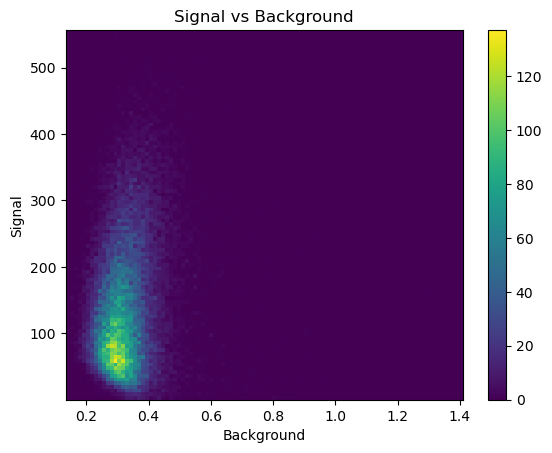

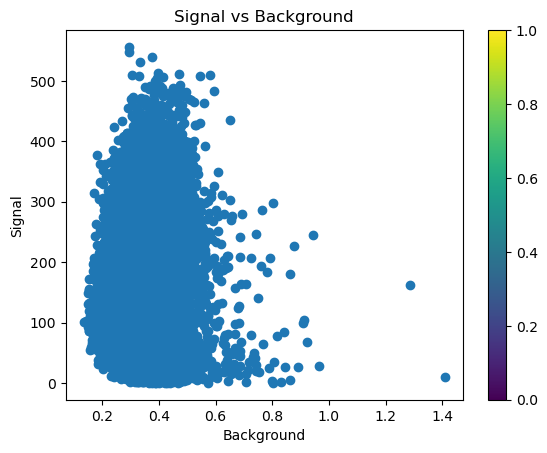

[[1.         0.18285571]
 [0.18285571 1.        ]]


In [14]:
import numpy as np
signal = np.array(detected_spots['intensity_from_neighborhood'])
background = np.array(detected_spots['background_intensity_from_neighborhood'])
print(signal.shape, background.shape)

plt.hist2d(x=background, y=signal, alpha=1, bins=100)
plt.colorbar()
plt.xlabel('Background')
plt.ylabel('Signal')
plt.title('Signal vs Background')
plt.show()

plt.figure()
plt.scatter(x=background, y=signal, alpha=1)
plt.colorbar()
plt.xlabel('Background')
plt.ylabel('Signal')
plt.title('Signal vs Background')
plt.show()

# Compute the correlation between signal and background
#np.corrcoef(signal, background)
print(np.corrcoef(signal, background))

[7.1229999  4.69527095 4.71284058 ... 1.90648236 3.77241464 3.63976846]


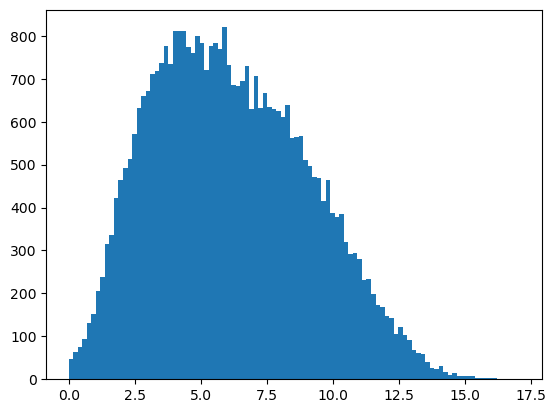

In [15]:
import numpy as np
snr = (
    detected_spots["intensity_from_neighborhood"]
    / detected_spots["intensity_std_error_from_neighborhood"]
)
print(np.array(snr))
## Make snr histogram
plt.figure()
plt.hist(snr, bins=100)
plt.show()

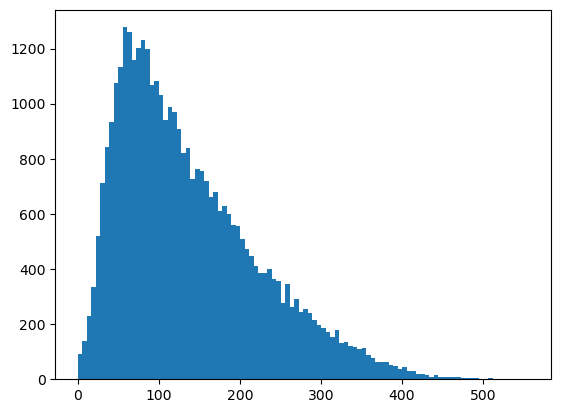

In [16]:
signal = (detected_spots["intensity_from_neighborhood"])

## Make signal histogram
plt.figure()
plt.hist(signal, bins=100)
plt.show()
# plt.close()

In [3]:
from transcription_pipeline.spot_analysis import compile_data

In [4]:
compiled_dataframe = compile_data.compile_traces(
    detected_spots,
    compile_columns_spot=[
        "frame",
        "t_s",
        "intensity_from_neighborhood",
        "intensity_std_error_from_neighborhood",
        "x",
        "y"
    ],
    nuclear_tracking_dataframe=None,
)

NameError: name 'detected_spots' is not defined

In [ ]:
compiled_dataframe

## Visualizing traces

In [19]:
from transcription_pipeline.utils import plottable
import matplotlib.pyplot as plt

In [1]:
# Restrict to longer traces
min_frames = 60
traces_compiled_dataframe = compiled_dataframe[
    compiled_dataframe["frame"].apply(lambda x: x.size) > min_frames
]

NameError: name 'compiled_dataframe' is not defined

In [ ]:
plt.close()

In [21]:
# %matplotlib widget
# This is taken from https://stackoverflow.com/questions/18390461/scroll-backwards-and-forwards-through-matplotlib-plots
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt


from scipy.signal import medfilt
from skimage.restoration import denoise_tv_chambolle

traces = plottable.generate_trace_plot_list(traces_compiled_dataframe)
#median_filtered_traces = [medfilt(trace[1], kernel_size=15) for trace in traces]

tv_denoised_traces = [
    denoise_tv_chambolle(trace[1], weight=1080, max_num_iter=500) for trace in traces
]
# potts_steps_traces = [
#     potts_l1.l1_potts_step_detection(trace[1], gamma=-5e3, weights=(1 / trace[2] ** 2))
#     for trace in traces
# ]


# plt.close()
# plt.plot(traces[curr_pos][0], traces[curr_pos][1], label="Original")otts_l1.l1_potts_step_detection(trace[1], gamma=-5e3, weights=(1 / trace[2] ** 2))
#     for trace in traces
# ]

curr_pos = 0


def key_event(e):
    global curr_pos

    if e.key == "right":
        curr_pos = curr_pos + 1
    elif e.key == "left":
        curr_pos = curr_pos - 1
    else:
        return
    curr_pos = curr_pos % len(traces)

    ax.cla()
    ax.errorbar(
        traces[curr_pos][0],
        traces[curr_pos][1],
        yerr=traces[curr_pos][2],
        fmt=".",
        elinewidth=1,
    )
    # ax.plot(traces[curr_pos][0], median_filtered_traces[curr_pos], color="k")
    ax.plot(traces[curr_pos][0], tv_denoised_traces[curr_pos], color="k", label="TV")
    # ax.step(
    #     traces[curr_pos][0],
    #     potts_steps_traces[curr_pos],
    #     where="mid",
    #     color="red",
    #     label="Potts L1",
    # )
    ax.set_xlabel("time (s)")
    ax.set_ylabel("Spot intensity (AU)")

    particle = traces[curr_pos][3]
    mean_x = (
        compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "x"]
        .values[0]
        .mean()
    )
    initial_frame = (
    compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "frame"]
    .values[0][0]
    )
    ax.set_title(f"Particle {particle}, x = {mean_x}, Initial frame {initial_frame}")
    ax.legend()
    fig.canvas.draw()


fig = plt.figure()
fig.canvas.mpl_connect("key_press_event", key_event)

ax = fig.add_subplot(111)
ax.errorbar(
    traces[curr_pos][0],
    traces[curr_pos][1],
    yerr=traces[curr_pos][2],
    fmt=".",
    elinewidth=1,
)
# ax.plot(traces[curr_pos][0], median_filtered_traces[curr_pos], color="k")
ax.plot(traces[curr_pos][0], tv_denoised_traces[curr_pos], color="k", label="TV")
# ax.step(
#     traces[curr_pos][0],
#     potts_steps_traces[curr_pos],
#     where="mid",
#     color="red",
#     label="Potts L1",
# )
ax.set_xlabel("time (s)")
ax.set_ylabel("Spot intensity (AU)")

particle = traces[curr_pos][3]
mean_x = (
    compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "x"]
    .values[0]
    .mean()
)
initial_frame = (
    compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "frame"]
    .values[0][0]
)
ax.set_title(f"Particle {particle}, x = {mean_x}, Initial frame {initial_frame}")
ax.legend()

plt.show()

/mnt/Data1/Nick/transcription_pipeline/transcription_pipeline/utils/plottable.py:17: UserWarning: Could not determine division time, using absolute time.
  warnings.warn("Could not determine division time, using absolute time.")


In [ ]:
print(traces)

In [ ]:
# Version without renormalization
from scipy.optimize import least_squares


def make_half_cycle(basal, t_on, t_dwell, rate, t_interp):
    half_cycle = np.zeros_like(t_interp)
    half_cycle[t_interp < t_on] = basal
    half_cycle[(t_interp >= t_on) & (t_interp < t_on + t_dwell)] = basal + rate * (t_interp[(t_interp >= t_on) & (t_interp < t_on + t_dwell)] - t_on)
    half_cycle[t_interp >= t_on + t_dwell] = basal + rate * t_dwell
    return half_cycle

def fit_func(params, MS2, timepoints, t_interp):
    return np.interp(timepoints, t_interp, make_half_cycle(*params, t_interp)) - MS2

def initial_guess(MS2, timepoints):
    # Initial guess for the parameters
    basal0 = MS2[0]
    t_on0 = timepoints[3]
    t_dwell0 = (2/3)*(timepoints[-1]-timepoints[0])
    rate0 = 1
    # print(np.max(mean_dy_dx))
    return [basal0, t_on0, t_dwell0, rate0]

def fit_half_cycle(MS2, timepoints, t_interp, max_nfev=3000):
    # Initial guess
    x0 = initial_guess(MS2, timepoints)
    # Parameter bounds
    lb = [np.min(MS2), 0, -2,  0]
    ub = [np.max(MS2), np.max(timepoints), np.max(timepoints), 1e7]

    # Perform the fit
    res = least_squares(fit_func, x0, bounds=(lb, ub), args=(MS2, timepoints, t_interp), max_nfev=max_nfev)

    # Extract fit parameters
    basal, t_on, t_dwell, rate = res.x
    resnorm = res.cost / len(MS2)  # Normalize residual norm by number of datapoints
    residual = res.fun

    # Calculate confidence intervals
    from scipy.stats import chi2
    alpha = 0.05  # 95% confidence interval
    dof = len(MS2) - len(res.x)
    tval = chi2.ppf(1.0 - alpha / 2., dof)

    pcov = np.linalg.inv(res.jac.T.dot(res.jac)) * res.cost / dof
    perr = np.sqrt(np.diag(pcov))
    CI = np.array([res.x - tval * perr, res.x + tval * perr]).T

    return basal, t_on, t_dwell, rate, residual, resnorm, CI

In [ ]:
pip install emcee

In [ ]:
import numpy as np
from scipy.optimize import least_squares
from scipy.stats import chi2
import pandas as pd
import emcee

# Version with normalization and regularization
def make_half_cycle(basal, t_on, t_dwell, rate, t_interp):
    half_cycle = np.zeros_like(t_interp)
    half_cycle[t_interp < t_on] = basal
    half_cycle[(t_interp >= t_on) & (t_interp < t_on + t_dwell)] = basal + rate * (t_interp[(t_interp >= t_on) & (t_interp < t_on + t_dwell)] - t_on)
    half_cycle[t_interp >= t_on + t_dwell] = basal + rate * t_dwell
    return half_cycle

def fit_func(params, MS2, timepoints, t_interp):
    return np.interp(timepoints, t_interp, make_half_cycle(*params, t_interp)) - MS2

def initial_guess(MS2, timepoints):
    # Initial guess for the parameters
    basal0 = MS2[0]
    t_on0 = timepoints[0]
    t_dwell0 = (2/3)*(timepoints[-1]-timepoints[0])
    rate0 = 1
    # print(np.max(mean_dy_dx))
    return [basal0, t_on0, t_dwell0, rate0]

# def fit_half_cycle(MS2, timepoints, t_interp, max_nfev=3000):
#     """NG: This script does fitting and error estimates using gradient descent followed by
#      minimizing the Jacobian; gives error bars that are too broad. 
#      """
#     # Initial guess
#     x0 = initial_guess(MS2, timepoints)
#     
#     # Parameter bounds
#     lb = [np.min(MS2), 0, 0, 0]  # Ensure t_dwell is non-negative
#     ub = [np.max(MS2), np.max(timepoints), np.max(timepoints), 1e7]
# 
#     # Scaling factors to normalize parameters
#     scale_factors = np.array([np.max(MS2), np.max(timepoints), np.max(timepoints), 100])
# 
#     # Scaled bounds
#     lb_scaled = np.array(lb) / scale_factors
#     ub_scaled = np.array(ub) / scale_factors
#     x0_scaled = np.array(x0) / scale_factors
# 
#     # Scaled fit function
#     def fit_func_scaled(params, MS2, timepoints, t_interp):
#         params_unscaled = params * scale_factors
#         return fit_func(params_unscaled, MS2, timepoints, t_interp)
# 
#     # Perform the fit with regularization
#     def residuals_with_regularization(params, MS2, timepoints, t_interp, reg=1e-3):
#         residuals = fit_func_scaled(params, MS2, timepoints, t_interp)
#         regularization = reg * np.sum(params[:]**2)
#         return residuals + regularization
# 
#     res = least_squares(residuals_with_regularization, 
#                         x0_scaled, bounds=(lb_scaled, ub_scaled), 
#                         args=(MS2, timepoints, t_interp), max_nfev=max_nfev)
#     
#     # Extract and rescale fit parameters
#     basal, t_on, t_dwell, rate = res.x * scale_factors
#     resnorm = res.cost / len(MS2)  # Normalize residual norm by number of data points
#     residual = res.fun * np.max(MS2)
# 
#     # Calculate confidence intervals
#     J = res.jac
#     try:
#         pcov = np.linalg.inv(J.T.dot(J)) * res.cost / (len(MS2) - len(res.x))
#         perr = np.sqrt(np.diag(pcov))
#     except np.linalg.LinAlgError:
#         perr = np.full(len(res.x), np.inf)
# 
#     alpha = 0.1 # 90% confidence interval
#     dof = len(MS2) - len(res.x)
#     tval = chi2.ppf(1.0 - alpha / 2., dof)
#     
#     CI = np.array([res.x - tval * perr, res.x + tval * perr]).T * scale_factors[:, np.newaxis]
# 
#     return basal, t_on, t_dwell, rate, residual, resnorm , CI

def fit_half_cycle(MS2, timepoints, t_interp, std_errors, max_nfev=3000):
    # Initial guess
    x0 = initial_guess(MS2, timepoints)
    
    # Parameter bounds
    lb = [np.min(MS2), 0, 0, 0]  # Ensure t_dwell is non-negative
    ub = [np.max(MS2), np.max(timepoints), np.max(timepoints), 1e7]

    # Scaling factors to normalize parameters
    scale_factors = np.array([np.max(MS2), np.max(timepoints), np.max(timepoints), 100])

    # Scaled bounds
    lb_scaled = np.array(lb) / scale_factors
    ub_scaled = np.array(ub) / scale_factors
    x0_scaled = np.array(x0) / scale_factors

    # Scaled fit function
    def fit_func_scaled(params, MS2, timepoints, t_interp):
        params_unscaled = params * scale_factors
        return fit_func(params_unscaled, MS2, timepoints, t_interp)

    # Negative log-likelihood function
    def negative_log_likelihood(params, MS2, timepoints, t_interp, std_errors, reg=1e-3):
        residuals = fit_func_scaled(params, MS2, timepoints, t_interp) / std_errors
        regularization = reg * np.sum(params[:]**2)
        nll = 0.5 * np.sum(residuals**2) + regularization
        return nll

    # Initial parameter estimation using least_squares
    res = least_squares(negative_log_likelihood, 
                        x0_scaled, bounds=(lb_scaled, ub_scaled), 
                        args=(MS2, timepoints, t_interp, std_errors), max_nfev=max_nfev)
    

    # Define log-probability function for MCMC
    def log_prob(params, MS2, timepoints, t_interp, std_errors, scale_factors, lb_scaled, ub_scaled):
        if np.any(params < lb_scaled) or np.any(params > ub_scaled):
            return -np.inf
        nll = negative_log_likelihood(params, MS2, timepoints, t_interp, std_errors)
        return -nll  # Convert to log-probability

    # MCMC parameters
    nwalkers = 10
    ndim = len(x0_scaled)
    nsteps = 1000
    initial_pos = res.x + 1e-4 * np.random.randn(nwalkers, ndim)

    # Run MCMC
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(MS2, timepoints, 
                                                                      t_interp, std_errors, 
                                                                    scale_factors, lb_scaled, ub_scaled))
    # Run MCMC until the acceptance fraction is at least 0.5
    sampler.run_mcmc(initial_pos, nsteps, progress=True); 

    # Flatten the chain and discard burn-in steps
    flat_samples = sampler.get_chain(discard=200, thin=15, flat=True)

    # Extract and rescale fit parameters
    basal, t_on, t_dwell, rate = np.median(flat_samples, axis=0) * scale_factors

    # Calculate confidence intervals
    CI = np.percentile(flat_samples, [5, 95], axis=0).T * scale_factors[:, np.newaxis]

    return basal, t_on, t_dwell, rate, CI

def first_derivative(x, y):
    """
    Compute the first discrete derivative of y with respect to x.
    Parameters:
    x (numpy.ndarray): Independent variable data points.
    y (numpy.ndarray): Dependent variable data points.
    Returns:
    numpy.ndarray: Discrete first derivative of y with respect to x.
    """
    dx = np.diff(x)
    dy = np.diff(y)
    dydx = dy / dx

    # Use central differences for the interior points and forward/backward differences for the endpoints
    dydx_central = np.zeros_like(y)
    dydx_central[1:-1] = (y[2:] - y[:-2]) / (x[2:] - x[:-2])
    dydx_central[0] = dydx[0]
    dydx_central[-1] = dydx[-1]

    return dydx_central

def mean_sign_intervals(function):
    """
    Compute the mean of function over intervals where the function has a constant sign.
    Parameters:
    derivative (numpy.ndarray): Array representing the function.
    Returns:
    numpy.ndarray: Array with mean values of the function over intervals with constant sign.
    """
    # Identify where the sign changes
    sign_changes = np.diff(np.sign(function))
    # Get indices where the sign changes
    change_indices = np.where(sign_changes != 0)[0] + 1

    # Initialize the list to hold mean values
    mean_values = []
    start_index = 0

    for end_index in change_indices:
        # Calculate the mean of the current interval
        interval_mean = np.mean(function[start_index:end_index])
        # Append the mean value to the list
        mean_values.extend([interval_mean] * (end_index - start_index))
        # Update the start index
        start_index = end_index

    # Handle the last interval
    interval_mean = np.mean(function[start_index:])
    mean_values.extend([interval_mean] * (len(function) - start_index))

    return np.array(mean_values), change_indices

# Function to generate fits for all traces
def fit_all_traces(traces, tv_denoised_traces):
    """
    Fit half-cycles to all traces in the dataset.
    Parameters:
    traces (list): List of traces to fit.
    tv_denoised_traces (list): List of TV denoised traces.
    Returns:
    list: List of tuples with fit parameters for each trace.
    """
    # Initialize the list to hold fit results
    fit_results = []

    # Create new dataframe to store fit results
    dataframe = pd.DataFrame(columns=['particle', 'fit_results'])
    
    for i in range(len(traces)):
        # Compute the first derivative of TV denoised with respect to time
        dy_dx = first_derivative(traces[i][0], tv_denoised_traces[i])

        # Compute the mean of the first derivative over intervals with constant sign
        mean_dy_dx, change_indices = mean_sign_intervals(dy_dx)

        # Keep datapoints from before first sign change
        try:
            timepoints = traces[i][0][:change_indices[0]]
            MS2 = traces[i][1][:change_indices[0]]
            MS2_std = traces[i][2][:change_indices[0]]

            # Interpolate the timepoints
            t_interp = np.linspace(min(timepoints), max(timepoints), 1000)
        except:
            print(f"Failed to find derivative sign change for trace {traces[i][3]}")
            fit_results.append([None, None, None, None, None])
            dataframe.loc[i] = [traces[i][3], [None, None, None, None, None]]
            continue


        # Compute the fit values
        try:
            basal, t_on, t_dwell, rate, CI = fit_half_cycle(MS2, timepoints, t_interp, MS2_std)
            fit_result = [timepoints, t_interp, MS2, make_half_cycle(basal, t_on, t_dwell, rate, t_interp),
                                [basal, t_on, t_dwell, rate, CI]]
            
            fit_results.append(fit_result)
            dataframe.loc[i] = [traces[i][3], fit_result]
        except:
            print(f"Failed to fit trace {traces[i][3]}")
            fit_results.append([timepoints,t_interp, MS2, None, None])
            dataframe.loc[i] = [traces[i][3], [timepoints,t_interp, MS2, None, None]]
            continue

    return fit_results, dataframe

In [ ]:
# Compute the first derivative of TV denoised with respect to time
dy_dx = first_derivative(traces[curr_pos][0], tv_denoised_traces[curr_pos])

# Compute the mean of the first derivative over intervals with constant sign
mean_dy_dx, change_indices= mean_sign_intervals(dy_dx)

## Keep datapoints from before first sign change
timepoints = traces[curr_pos][0][:change_indices[0]]  
MS2 = traces[curr_pos][1][:change_indices[0]]
MS2_std = traces[curr_pos][2][:change_indices[0]]  
# Interpolate the timepoints
t_interp = np.linspace(min(timepoints), max(timepoints), 1000)

# Compute the fit values
basal, t_on, t_dwell, rate, CI = fit_half_cycle(MS2, timepoints, t_interp, MS2_std, max_nfev=3000)

print("Fitted parameters:")
print(f"basal: {basal}, t_on: {t_on}, t_dwell: {t_dwell}, rate: {rate}")

# Print confidence intervals and parameter names
param_names = ['basal', 't_on', 't_dwell', 'rate']
for i, name in enumerate(param_names):
    print(f"{name}: {CI[i]}")

# Plot the data and the fit
plt.figure()
plt.errorbar(traces[curr_pos][0], traces[curr_pos][1], yerr=traces[curr_pos][2], 
             fmt='.',elinewidth=1, label="Data")
plt.plot(t_interp, make_half_cycle(basal, t_on, t_dwell, rate, t_interp), label="Fit", linewidth=3)
plt.xlabel("time (s)")
plt.ylabel("Spot intensity (AU)")
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from skimage.restoration import denoise_tv_chambolle

# Restrict to longer traces
min_frames = 40
traces_compiled_dataframe = compiled_dataframe[
    compiled_dataframe["frame"].apply(lambda x: x.size) > min_frames
]
# Restrict to traces starting at frame nc14_frame and above
nc14_frame = 400
traces_compiled_dataframe = traces_compiled_dataframe[
    traces_compiled_dataframe["frame"].apply(lambda x: x[0] >= nc14_frame)
]

# Order the traces based on the mean x position
traces_compiled_dataframe = traces_compiled_dataframe.sort_values(
    by="x", key=lambda x: x.apply(np.mean)
)

traces = plottable.generate_trace_plot_list(traces_compiled_dataframe)


# Generate TV denoised traces
tv_denoised_traces = [
    denoise_tv_chambolle(trace[1], weight=1080, max_num_iter=500) for trace in traces
]

# Generate fits for all traces
fit_results, dataframe = fit_all_traces(traces, tv_denoised_traces);

print(f"Number of traces: {len(traces)}")

# Show number of traces with valid fits
print(f"Number of traces with valid fits: {sum([result[4] is not None for result in fit_results])}")

# Show number of traces with invalid fits
print(f"Number of traces with invalid fits: {sum([result[4] is None for result in fit_results])}")

traces_compiled_dataframe_fits = pd.merge(traces_compiled_dataframe, dataframe, on='particle', how='inner')

# Add columns: the approval status, denoised trace, and fitted rate of the particle
length = traces_compiled_dataframe_fits.index.max()
status = [1 for _ in range(length+1)]
traces_compiled_dataframe_fits['tv_denoised_trace'] = tv_denoised_traces
traces_compiled_dataframe_fits['approval_status'] = status

traces_compiled_dataframe_fits.head()

In [ ]:
from warnings import warn

### Josh's Fit checking function
def check_particle_fit(binned_particles_fitted):
    '''
    Check the fit of each particle. All particles are approved by default.
    '''

    fig, ax = plt.subplots()
    
    particle_index = 0
    particle_num = binned_particles_fitted.index.max()

    # move to the first unchecked particle--------------------------------------
    # first_flag = False
    # while not first_flag:
    #     particle_data = binned_particles_fitted[particle_index:particle_index+1]
    #     status = particle_data['approval_status'].values[0]
    #     if status == 0:
    #         first_flag = True
    #     else:
    #         if particle_index < particle_num:
    #             particle_index += 1
    #         elif particle_index == particle_num:
    #             warn('No particle has been left unchecked')
    #             break
    #---------------------------------------------------------------------------
    
    def update_plot(particle_index):
        ax.clear()
        try:
            particle_data = binned_particles_fitted[particle_index:particle_index+1] # select the particle
            
            x = particle_data['t_s'].values[0]
            y = particle_data['intensity_from_neighborhood'].values[0]
            y_denoised = particle_data['tv_denoised_trace'].values[0]
            y_err = particle_data['intensity_std_error_from_neighborhood'].values[0]
    
            # plot the particle trace with error bar along with the denoised trace
            ax.errorbar(x, y, yerr=y_err, fmt=".", elinewidth=1, label='Data')
            ax.plot(x, y_denoised, color='k', label='TV denoised')
    
            # plot the half cycle fit
            try:
                fit_result = particle_data['fit_results'].values[0]
                timepoints, t_interp, MS2, half_cycle_fit, [basal, t_on, t_dwell, rate, CI] = fit_result
    
                ax.plot(t_interp, half_cycle_fit, label=f'Fit (slope = {round(rate,2)})', linewidth=3)
    
                # ax.plot(t_interp, make_half_cycle(basal, t_on, t_dwell, rate, t_interp), label=f"Fit (slope = {round(rate, 2)})", linewidth=3, color='orange')
            except:
                pass
    
            particle = particle_data['particle'].values[0]
            # bin = particle_data['bin'].values[0]
            mean_x = (particle_data.loc[particle_data["particle"] == particle, "x"]
            .values[0]
            .mean()
            )
            initial_frame = (compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "frame"].
            values[0][0]
            )
            status = particle_data['approval_status'].values[0]
    
            if status == 1:
                ax.set_facecolor((0.7, 1, 0.7)) # approve
            elif status == -1:
                ax.set_facecolor((1, 0.7, 0.7)) # reject color
            elif status == 0:
                ax.set_facecolor((1, 1, 1))
            elif status == 2:
                ax.set_facecolor((1, 1, 0.7))
            
            ax.set_title(f'Particle #{particle} ({particle_index+1}/{particle_num+1}), x = {np.round(mean_x, 2)}, Initial frame {initial_frame}')
            ax.set_xlabel("Time (s)")
            ax.set_ylabel("Spot intensity (AU)")
            ax.legend()

        except Exception as e:
            particle = particle_data['particle'].values[0]
            print(f"Error processing particle {particle}: {e}")

        fig.canvas.draw()

    def on_key(event):
        nonlocal particle_index
        if event.key == 'left':
            particle_index = max(0, particle_index - 1)
        elif event.key == 'right':
            particle_index = min(len(binned_particles_fitted) - 1, particle_index + 1)
        elif event.key == 'a':
            binned_particles_fitted.at[particle_index, 'approval_status'] = 1
        elif event.key == 'r':
            binned_particles_fitted.at[particle_index, 'approval_status'] = -1
        elif event.key == 'c':
            binned_particles_fitted.at[particle_index, 'approval_status'] = 0
        elif event.key == 'p':
            binned_particles_fitted.at[particle_index, 'approval_status'] = 2
        update_plot(particle_index)

    update_plot(particle_index)
    fig.canvas.mpl_connect('key_press_event', on_key)
    plt.show()

In [ ]:
%matplotlib widget
plt.close()

curr_pos = 0


def key_event(e):
    global curr_pos

    if e.key == "right":
        curr_pos = curr_pos + 1
    elif e.key == "left":
        curr_pos = curr_pos - 1
    else:
        return
    curr_pos = curr_pos % len(traces)

    ax.cla()
    ax.errorbar(
        traces[curr_pos][0],
        traces[curr_pos][1],
        yerr=traces[curr_pos][2],
        fmt=".",
        elinewidth=1,
    )

    ax.plot(traces[curr_pos][0], tv_denoised_traces[curr_pos], color="k", label="TV")

    # Plot the fit if it exists
    try:
        ax.plot(fit_results[curr_pos][1], fit_results[curr_pos][3], label="Fit", linewidth=3)
    except:
        pass

    ax.set_xlabel("time (s)")
    ax.set_ylabel("Spot intensity (AU)")

    particle = traces[curr_pos][3]
    mean_x = (
        compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "x"]
        .values[0]
        .mean()
    )
    initial_frame = (
    compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "frame"]
    .values[0][0]
    )
    try:
        rate = fit_results[curr_pos][4][3]
    except:
        rate = np.nan

    ax.set_title(f"Particle {particle}, x = {mean_x:.2f}, Initial frame {initial_frame}, Rate {rate:.2f} AU/s")
    ax.legend()
    fig.canvas.draw()


fig = plt.figure()
fig.canvas.mpl_connect("key_press_event", key_event)

ax = fig.add_subplot(111)
ax.errorbar(
    traces[curr_pos][0],
    traces[curr_pos][1],
    yerr=traces[curr_pos][2],
    fmt=".",
    elinewidth=1,
)

ax.plot(traces[curr_pos][0], tv_denoised_traces[curr_pos], color="k", label="TV")

# Plot the fit if it exists
try:
    ax.plot(fit_results[curr_pos][1], fit_results[curr_pos][3], label="Fit", linewidth=3)
except:
    pass

ax.set_xlabel("time (s)")
ax.set_ylabel("Spot intensity (AU)")

particle = traces[curr_pos][3]
mean_x = (
    compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "x"]
    .values[0]
    .mean()
)
initial_frame = (
    compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "frame"]
    .values[0][0]
)
try:
    rate = fit_results[curr_pos][4][3]
except:
    rate = np.nan

ax.set_title(f"Particle {particle}, x = {mean_x:.2f}, Initial frame {initial_frame}, Rate {rate:.2f} AU/s")
ax.legend()

plt.show()

In [ ]:
check_particle_fit(traces_compiled_dataframe_fits)

In [ ]:
plt.close()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a DataFrame called 'dataframe' with a column 'mean_x' representing the mean x position
# and a column 'rate' representing the fit rates

# Define the number of bins and the bin width
num_bins = 16
bin_width = 1024 // num_bins

# Create an array to store the bin indices for each trace
bin_indices = np.zeros(len(traces_compiled_dataframe_fits))

# Loop through traces_compiled_dataframe_fits and assign each trace to a bin based on mean_x position
for i in range(len(traces_compiled_dataframe_fits)):
    particle = traces_compiled_dataframe_fits['particle'][i]
    bin_indices[i] = (
        int(traces_compiled_dataframe_fits.loc[traces_compiled_dataframe_fits['particle'] == particle, 'x']
        .values[0].mean()) // bin_width
    )

# Calculate the number of traces in each bin
bin_counts = np.zeros(num_bins)
for i in range(num_bins):
    bin_counts[i] = np.sum(bin_indices == i)

print(bin_counts)
print(np.sum(bin_counts))

# Calculate the average fit rates for each bin and store particle IDs with rates in each bin
mean_fit_rates = np.zeros(num_bins)
bin_particles_rates = np.zeros(num_bins, dtype=object)
SE_fit_rates = np.zeros(num_bins)
for i in range(num_bins):
    if bin_counts[i] == 0:
        mean_fit_rates[i] = np.nan
        continue
    else:
        rates = (
            60*traces_compiled_dataframe_fits.loc[bin_indices == i, 'fit_results'].apply(
                lambda x: x[4][3] if x[4] is not None else np.nan).values
            )
        particles = (
            traces_compiled_dataframe_fits.loc[bin_indices == i, 'particle']
            .values
            )
        
        # Store the particle IDs with their rates in each bin for further analysis
        bin_particles_rates[i] = {
            'bin': i,
            'particles': particles,
            'rates': rates
        }
        
        mean_fit_rates[i] = (np.nanmean(rates))

        # Standard error of the mean
        SE_fit_rates[i] = np.nanstd(rates) / np.sqrt(len(rates))


# Plot the mean slopes for each bin number
plt.figure()
plt.errorbar(np.arange(num_bins), mean_fit_rates, yerr=SE_fit_rates, fmt='o')
plt.xlabel('Bin number')
plt.ylabel('Mean fit rate (AU/min)')
plt.ylim(0,300)
plt.show()

In [ ]:
print(bin_particles_rates)

In [ ]:
plt.close('all')

In [ ]:
plt.close()

In [ ]:
particle = traces[curr_pos][3]
x = (
        compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "x"]
        .values[0]
    )
y = (
        compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "y"]
        .values[0]
    )
t = traces[curr_pos][0]
# Create a colormap ranging from 0 to 1
cmap = plt.get_cmap('plasma')

# Normalize time values to [0,1] for color mapping
norm = plt.Normalize(t.min(), t.max())
colors = cmap(norm(t))

# Plot x and y positions with color changing with time
plt.figure()
plt.scatter(x, y, c=colors, cmap='plasma', s=10)
plt.colorbar(label='Time')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.xlim([0, 1024])
plt.ylim([0, 256])
plt.title('Particle position as a function of time')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# plt.figure()
# plt.scatter(t,x, marker='.')
# plt.ylabel('x coordinate')
# plt.xlabel('time (s)')
# plt.show()

In [ ]:
import pandas as pd
import numpy as np
print(compiled_dataframe.index)
Bins = pd.cut(compiled_dataframe["x"]
        .values[0]
        .mean(), bins=10)

In [ ]:
curr_pos

In [ ]:
plt.close()

In [ ]:
# Indices: 9, 13, 14?, 36, 58

In [ ]:
i = 58
fig = plt.figure()
# Step-like particles: 64, 72?, 87, 152fig = plt.figure()
fig.canvas.mpl_connect("key_press_event", key_event)

ax = fig.add_subplot(111)
ax.errorbar(
    traces[i][0],
    traces[i][1],
    yerr=traces[i][2],
    fmt=".",
    elinewidth=1,
)
# ax.plot(traces[curr_pos][0], median_filtered_traces[curr_pos], color="k")
ax.plot(traces[i][0], tv_denoised_traces[i], color="k", label="TV denoised trace")
# ax.step(
#     traces[curr_pos][0],
#     potts_steps_traces[curr_pos],
#     where="mid",
#     color="red",
#     label="Potts L1",
# )
ax.set_xlabel("time (s)")
ax.set_ylabel("Spot intensity (AU)")

particle = traces[i][3]
# mean_x = (
#     compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "x"]
#     .values[0]
#     .mean()
# )
# ax.set_title(f"Particle {particle}, x = {mean_x}")
ax.legend()
plt.savefig("halotag_sm_trace_4.svg", format="svg")
plt.savefig("halotag_sm_trace_4.eps", format="eps")

plt.show()

## Testing

In [ ]:
plt.close()

In [ ]:
%matplotlib widget
# This is taken from https://stackoverflow.com/questions/18390461/scroll-backwards-and-forwards-through-matplotlib-plots
import matplotlib.pyplot as plt

from scipy.signal import medfilt
from skimage.restoration import denoise_tv_chambolle


traces = plottable.generate_trace_plot_list(traces_compiled_dataframe)
median_filtered_traces = [medfilt(trace[1], kernel_size=15) for trace in traces]

# tv_denoised_traces = [
#     denoise_tv_chambolle(trace[1], weight=180, max_num_iter=500) for trace in traces
# ]
# potts_steps_traces = [
#     potts_l1.l1_potts_step_detection(trace[1], gamma=-5e3, weights=(1 / trace[2] ** 2))
#     for trace in traces
# ]

curr_pos = 0


def key_event(e):
    global curr_pos

    if e.key == "right":
        curr_pos = curr_pos + 1
    elif e.key == "left":
        curr_pos = curr_pos - 1
    else:
        return
    curr_pos = curr_pos % len(traces)

    ax.cla()
    ax.errorbar(
        traces[curr_pos][0],
        traces[curr_pos][1],
        yerr=traces[curr_pos][2],
        fmt=".",
        elinewidth=1,
    )
    ax.plot(
        traces[curr_pos][0],
        median_filtered_traces[curr_pos],
        color="k",
        label="Median filtered",
    )
    # ax.plot(traces[curr_pos][0], tv_denoised_traces[curr_pos], color="k", label="TV")
    # ax.step(
    #     traces[curr_pos][0],
    #     potts_steps_traces[curr_pos],
    #     where="mid",
    #     color="red",
    #     label="Potts L1",
    # )
    ax.set_xlabel("time (s)")
    ax.set_ylabel("Spot intensity (AU)")

    particle = traces[curr_pos][3]
    mean_x = (
        compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "x"]
        .values[0]
        .mean()
    )
    ax.set_title(f"Particle {particle}, x = {mean_x}")
    ax.legend()
    fig.canvas.draw()


fig = plt.figure()
fig.canvas.mpl_connect("key_press_event", key_event)

ax = fig.add_subplot(111)
ax.errorbar(
    traces[curr_pos][0],
    traces[curr_pos][1],
    yerr=traces[curr_pos][2],
    fmt=".",
    elinewidth=1,
)
ax.plot(
    traces[curr_pos][0],
    median_filtered_traces[curr_pos],
    color="k",
    label="Median filtered",
)
# ax.plot(traces[curr_pos][0], tv_denoised_traces[curr_pos], color="k", label="TV")
# ax.step(
#     traces[curr_pos][0],
#     potts_steps_traces[curr_pos],
#     where="mid",
#     color="red",
#     label="Potts L1",
# )
ax.set_xlabel("time (s)")
ax.set_ylabel("Spot intensity (AU)")

particle = traces[curr_pos][3]
mean_x = (
    compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "x"]
    .values[0]
    .mean()
)
ax.set_title(f"Particle {particle}, x = {mean_x}")
ax.legend()

plt.show()

In [ ]:
curr_pos

In [ ]:
i = 13
time, trace, filt_trace = traces[i][0], traces[i][1], median_filtered_traces[i]

In [ ]:
down_time_mask = time > 580
down_time, down_trace, down_filt_trace = (
    time[down_time_mask],
    trace[down_time_mask],
    filt_trace[down_time_mask],
)

In [ ]:
plt.close()

In [ ]:
plt.close()
plt.hist(down_trace, bins=12)

In [ ]:
import numpy as np

In [ ]:
pooled_intensities = np.array([])
for trace_tuple in traces:
    pooled_intensities = np.append(pooled_intensities, trace_tuple[1])

In [ ]:
pooled_errors = np.array([])
for trace_tuple in traces:
    pooled_errors = np.append(pooled_errors, trace_tuple[2])

pooled_inv_var = 1 / (pooled_errors**2)

In [ ]:
plt.close()
plt.hist(pooled_intensities, weights=pooled_inv_var, bins=120, log=False)
plt.show()

In [ ]:
from scipy import stats, signal

In [ ]:
kde_estimate = stats.gaussian_kde(
    pooled_intensities, weights=pooled_inv_var, bw_method=0.04
)
intensity_val_hist = np.linspace(
    pooled_intensities.min(), pooled_intensities.max(), num=500
)
kde_values = kde_estimate(intensity_val_hist)

peaks = signal.find_peaks(kde_values, height=0.0003)
peak_x_values = intensity_val_hist[peaks[0]]
peak_y_values = kde_values[peaks[0]]

In [ ]:
spacing = peak_x_values[1:] - peak_x_values[:-1]

In [ ]:
spacing

In [ ]:
approx_num_steps = np.round(peak_x_values / 66.37)

In [ ]:
regression = stats.linregress(approx_num_steps, peak_x_values)
mean_spacing = regression.slope
intercept = regression.intercept

In [ ]:
regression

In [ ]:
plt.close()
plt.plot(intensity_val_hist, kde_values, label="KDE of MS2 spot intensities")
plt.plot(
    peak_x_values,
    peak_y_values,
    linestyle="",
    marker="o",
    markersize=4,
    color="k",
    label="KDE Peaks",
)
plt.axvline(
    x=mean_spacing + intercept,
    color="r",
    ls=":",
    label="Calibrated single-mRNA peaks",
)
for i in range(2, 15):
    plt.axvline(
        x=i * mean_spacing + intercept,
        color="r",
        ls=":",
    )

plt.xlabel("MS2 spot intensity (AU)")
plt.ylabel("Density")

plt.legend()

# plt.savefig("HaloTag_single_mRNA_calibration.eps", format='eps')
# plt.savefig("HaloTag_single_mRNA_calibration.svg", format='svg')
plt.show()

In [ ]:
plt.close()
plt.hist(
    pooled_intensities,
    weights=pooled_inv_var,
    bins=120,
    log=False,
    label="Histrogram of MS2 spot intensities",
    density=True,
)
# plt.plot(
#     peak_x_values,
#     peak_y_values,
#     linestyle="",
#     marker="o",
#     markersize=4,
#     color="k",
#     label="KDE Peaks",
# )
plt.axvline(
    x=mean_spacing + intercept,
    color="r",
    ls=":",
    label="Calibrated single-mRNA peaks",
)
for i in range(2, 15):
    plt.axvline(
        x=i * mean_spacing + intercept,
        color="r",
        ls=":",
    )

plt.xlabel("MS2 spot intensity (AU)")
plt.ylabel("Frequency")

plt.legend()

plt.savefig("HaloTag_single_mRNA_calibration_histogram.eps", format="eps")
plt.savefig("HaloTag_single_mRNA_calibration_histogram.svg", format="svg")
plt.show()